In [173]:
import os
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.interpolate import interp1d

from IPython.display import clear_output

from tqdm import tqdm_notebook,tqdm

from copy import copy,deepcopy

#import seaborn as sb

matplotlib.style.use('ggplot')

## read data

In [174]:
data = pd.read_excel('20201207_15_EdU_chase_controls_Counts_Tiago.xls').dropna()
data['timepoint'] = pd.to_numeric(data['TIMEPOINT'].apply(lambda s: s[3:]))

In [175]:
data.head()

,TIMEPOINT,SAMPLE,COUNTS (total),ETP,ETP_EDU,DN2,DN2_EDU,DN3,DN3_EDU,DN4,DN4_EDU,ISP,ISP_EDU,DP,DP_EDU,timepoint
0,DAY0.5,__WT_B6_day0_5_001.fcs,60000000.0,4208.040072,1805.249191,115108.56000,59856.451200,616295.5200,160853.130720,395224.168320,362420.562349,338364.0,326859.6240,49740000.0,13131360.0,0.5
1,DAY0.5,__WT_B6_day0_5_002.fcs,48000000.0,3569.367914,1270.694978,86589.86112,45979.216255,482632.0128,118244.843136,217169.196768,190457.385566,214281.6,205281.7728,40608000.0,6456672.0,0.5
2,DAY0.5,__WT_B6_day0_5_003.fcs,49000000.0,4110.306891,1467.379560,89685.35268,50313.482853,512825.3368,120513.954148,298946.449099,274432.840273,275825.9,270861.0338,41601000.0,10400250.0,0.5
4,DAY1,__WT_B6_day1_001.fcs,51000000.0,2347.930852,448.454793,166667.67360,47833.622323,567133.0560,90174.155904,213470.039693,108869.720243,184558.8,108336.0156,43197000.0,10280886.0,1.0
5,DAY1,__WT_B6_day1_002.fcs,71000000.0,4041.470316,1713.583414,270389.69760,145740.047006,763251.9312,201498.509837,369064.823952,294882.794338,407106.9,341969.7960,59924000.0,21872260.0,1.0


In [406]:
variabs = ['DN2','DN3','DN4','ISP','DP']

data['Total'] = data.apply(lambda r: np.sum([ r[lab] for lab in variabs ] ) ,axis=1)

dfs = []
for i,var in enumerate(variabs):
#    data[var.lower()] = (data[var+'-EdU+']/data[var+'-Total'])*(data[var+'-Donor']/data[var+'-Total']) # assuming independence

    data[var.lower()] = (data[var+'_EDU']/(data[var]+data[var+'_EDU']))
#     data[var.lower()] = (data[var+'-EdU+']/data[var+'-Donor'])
    data[var+'_frac'] = data[var.lower()]
    df = data[['timepoint',var.lower()]].copy()
    df['t'] = df['timepoint']+i*10
    df.rename(columns={var.lower():'y'},inplace=True)
    dfs.append(df[['t','y']])

dfs = pd.concat(dfs).dropna()



In [186]:
variabs = ['DN2','DN3','DN4','ISP','DP']

data['Total'] = data.apply(lambda r: np.sum([ r[lab] for lab in variabs ] ) ,axis=1)

dfs_T = []
for i,var in enumerate(variabs):
    data[var.lower()+'_T'] = (data[var])/data['Total']
    df = data[['timepoint',var.lower()+'_T']].copy()
    df['t'] = df['timepoint']+i*10
    df.rename(columns={var.lower()+'_T':'y'},inplace=True)
    dfs_T.append(df[['t','y']])

dfs_T = pd.concat(dfs_T).dropna()

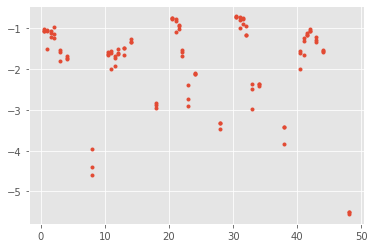

In [187]:
plt.plot(dfs['t'],np.log(dfs['y']),ls='',marker='.')

In [188]:
Ns = []
for i in [10,20,30,40,50]:
    mean = dfs_T.query("(t>(@i-10))&(t<@i)")['y'].mean()
    Ns.append(mean)
    
Ns

[0.0033111765486962567,
 0.01231169843067452,
 0.0053931878388306705,
 0.004609293478396721,
 0.9743746437034018]

## define functions

In [189]:
def calc_r2(func,xdata,ydata,params):
    residuals = ydata - func(xdata,*params)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata - np.sum(ydata))**2)
    r_sq = 1-(ss_res/ss_tot)
    return r_sq

def calc_residuals(func,xdata,ydata,params):
    residuals = ydata - func(xdata,*params)
    ss_res = np.sum(residuals**2)
    return ss_res

def calc_eff(params,idx,p_range):
    res0 = calc_residuals(func3,dfs['t'],dfs['y'] , params)
    set_list = []
    new_params = copy(params)
    for p in p_range:
        new_params[idx] = p   
        res = calc_residuals(func3,dfs['t'],dfs['y'] , new_params)
        set_list.append(res/res0)
    return np.array(set_list)

In [613]:
def f_full(y,t,params):
    alpha,k2,k3,k4,kisp,d2,d3,d4,disp,ddp,r2,r3,r4,risp,rdp = params
    dn2,dn3,dn4,isp,dp,dn2u,dn3u,dn4u,ispu,dpu = y

    dydt = [(1-alpha)*r2*dn2 - k2*dn2 -d2*dn2,\
            (1-alpha)*r3*dn3 + k2*dn2 -k3*dn3 -d3*dn3,\
            (1-alpha)*r4*dn4 + k3*dn3 - k4*dn4 - d4*dn4,\
            (1-alpha)*risp*isp + k4*dn4 - kisp*isp - disp*isp,\
            (1-alpha)*rdp*dp + kisp*isp -ddp*dp,\
            r2*dn2u + alpha*r2*dn2 - k2*dn2u-d2*dn2u,\
            r3*dn3u + alpha*r3*dn3 + k2*dn2u - k3*dn3u-d3*dn3u,\
            r4*dn4u + alpha*r4*dn4 + k3*dn3u - k4*dn4u - d4*dn4u,\
            risp*ispu + alpha*risp*isp + k4*dn4u - kisp*ispu - disp*ispu,\
            rdp*dpu + alpha*rdp*dp + kisp*ispu -ddp*dpu\
           ]
    return dydt

def f_full_transplant(y,t,params):
    alpha,k3,k4,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp = params
    dn3,dn4,isp,dp,dn3u,dn4u,ispu,dpu = y

    dydt = [(1-alpha)*r3*dn3 -k3*dn3 -d3*dn3,\
            (1-alpha)*r4*dn4 + k3*dn3 - k4*dn4 - d4*dn4,\
            (1-alpha)*risp*isp + k4*dn4 - kisp*isp - disp*isp,\
            (1-alpha)*rdp*dp + kisp*isp -ddp*dp,\
            r3*dn3u + alpha*r3*dn3 - k3*dn3u-d3*dn3u,\
            r4*dn4u + alpha*r4*dn4 + k3*dn3u - k4*dn4u - d4*dn4u,\
            risp*ispu + alpha*risp*isp + k4*dn4u - kisp*ispu - disp*ispu,\
            rdp*dpu + alpha*rdp*dp + kisp*ispu -ddp*dpu\
           ]
    return dydt

def full_model(t,alpha,k2,k3,k4,kisp,d2,d3,d4,disp,ddp,r2,r3,r4,risp,rdp,dn20,dn30,dn40,isp0,dp0):
    """
    function for curve_fit
    solves ODEs and puts the output in a single line (so that we are optimizing a single function)
    """
    params = alpha,k2,k3,k4,kisp,d2,d3,d4,disp,ddp,r2,r3,r4,risp,rdp
    y0 = [Ns[0]*dn20,Ns[1]*dn30,Ns[2]*dn40,Ns[3]*isp0,Ns[4]*dp0,Ns[0]*(1-dn20),Ns[1]*(1-dn30),Ns[2]*(1-dn40),Ns[3]*(1-isp0),Ns[4]*(1-dp0)]
    
    # variabs = ['DN3','DN4','ISP','DP']
    # solve and interpolate with these params
    
    tt=np.arange(0,10,.1)
    psoln = odeint(f_full, y0, tt, args=(params,))
    sol = [interp1d(tt,psoln[:,i]) for i in range(10) ]
    # get the values for t (** the original values **)
    sol_idx = [ divmod(t1,10) for t1 in t[t<50] ]

#     values = [ sol[int(idx[0])](idx[1]) for idx in sol_idx]

    values = [ sol[int(idx[0])](idx[1])/(sol[int(idx[0])](idx[1])+sol[int(idx[0])+5](idx[1]))  for idx in sol_idx ]
#     print(values)
    return np.array(values)

In [204]:
init_alpha=[0]
init_k = [.01,.01,1,.02]
init_d = [.01,.012,.0015,.014,.01]
init_r=[.1,.2,.1,.01,.1]
init_0=[1,1,0.1,1,0.1]

bounds_a = [[0,1]]
bounds_k = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf]]
bounds_d = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_r = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_0 = [ [0,1],[0,1],[0,1],[0,1],[0,1] ]

full_params,cov = curve_fit(full_model,dfs['t'],dfs['y'],\
                            p0=init_alpha+init_k+init_d+init_r+init_0,\
                            bounds=np.array(bounds_a+bounds_k+bounds_d+bounds_r+bounds_0).T,\
                            maxfev = 5000 )

calc_residuals(full_model,dfs['t'],dfs['y'],full_params)

0.22273631816524295

In [192]:
full_params

array([1.40126639e-01, 1.06510689e-01, 8.72223753e-17, 5.56471159e-09,
       4.61377770e+00, 8.10294543e-01, 4.26073271e-01, 3.19867239e-02,
       2.72072876e+00, 2.75188807e+00, 1.62752945e+00, 3.65198380e-26,
       3.86368661e+00, 6.99417102e-01, 9.71118260e-34, 4.25786302e-01,
       1.81976112e-01, 6.70532333e-01, 5.06686742e-01, 2.75335771e-01])

## Sample params

In [206]:
sampled_params = []

In [207]:
bounds_a = [[0,1]]
bounds_k = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf]]
bounds_d = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_r = [ [0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf],[0,np.inf] ]
bounds_0 = [ [0,1],[0,1],[0,1],[0,1],[0,1] ]

In [217]:
for n in tqdm(range(1000)):
    init_alpha=np.random.uniform(0,1,1).tolist()
    init_k = np.random.uniform(0,10,4).tolist()
    init_d = np.random.uniform(0,10,5).tolist()
    init_r= np.random.uniform(0,10,5).tolist()
    init_0=[1,1,0.,1,0]

    init_guess=init_alpha+init_k+init_d+init_r+init_0
    
    try:
        samp_params,cov = curve_fit(full_model,dfs['t'],dfs['y'],p0=init_guess,\
                               bounds=np.array(bounds_a+bounds_k+bounds_d+bounds_r+bounds_0).T,\
                               maxfev = 5000 )
        res = calc_residuals(full_model,dfs['t'],dfs['y'] , samp_params)
        sampled_params.append(samp_params.tolist()+[res])
    except Exception as e:
        print(e)
        continue

  3%|▎         | 30/1000 [01:19<30:34,  1.89s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
  3%|▎         | 31/1000 [01:19<22:43,  1.41s/it]

array must not contain infs or NaNs


  3%|▎         | 34/1000 [01:24<23:28,  1.46s/it]/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
  4%|▍         | 39/1000 [22:08<98:31:29, 369.08s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


  4%|▍         | 41/1000 [22:11<48:22:13, 181.58s/it]

array must not contain infs or NaNs


 25%|██▌       | 253/1000 [1:04:50<1:17:03,  6.19s/it]/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
 25%|██▌       | 254/1000 [1:04:51<54:53,  4.41s/it]  

array must not contain infs or NaNs


 28%|██▊       | 281/1000 [1:57:17<55:11:42, 276.36s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 30%|██▉       | 298/1000 [1:59:54<1:11:06,  6.08s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
 30%|██▉       | 299/1000 [1:59:55<51:05,  4.37s/it]  

array must not contain infs or NaNs


 36%|███▌      | 358/1000 [2:10:45<2:28:25, 13.87s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 36%|███▌      | 360/1000 [2:10:50<1:26:57,  8.15s/it]/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
 36%|███▌      | 361/1000 [2:10:51<1:01:59,  5.82s/it]

array must not contain infs or NaNs


 37%|███▋      | 369/1000 [2:15:31<1:49:29, 10.41s/it]

array must not contain infs or NaNs


 41%|████      | 411/1000 [2:36:56<44:30:56, 272.08s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 44%|████▎     | 437/1000 [2:39:04<24:37,  2.62s/it]

array must not contain infs or NaNs


 51%|█████     | 511/1000 [2:56:18<1:42:56, 12.63s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:9: Runtime

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 53%|█████▎    | 530/1000 [3:41:38<5:32:20, 42.43s/it]  /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
 58%|█████▊    | 582/1000 [3:56:20<1:10:22, 10.10s/it]

array must not contain infs or NaNs


 65%|██████▌   | 651/1000 [4:33:41<37:15:18, 384.29s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 70%|██████▉   | 696/1000 [4:55:56<28:57:55, 343.01s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 73%|███████▎  | 734/1000 [5:05:25<18:46,  4.23s/it]    /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
 74%|███████▎  | 735/1000 [5:05:25<14:02,  3.18s/it]

array must not contain infs or NaNs


 74%|███████▎  | 736/1000 [5:05:30<15:20,  3.49s/it]/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


Residuals are not finite in the initial point.


 75%|███████▌  | 751/1000 [5:07:01<11:09,  2.69s/it]

array must not contain infs or NaNs


 76%|███████▌  | 757/1000 [5:07:16<08:01,  1.98s/it]

array must not contain infs or NaNs


 79%|███████▊  | 786/1000 [5:36:38<26:44:36, 449.89s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 79%|███████▊  | 787/1000 [5:57:41<41:03:48, 694.03s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 81%|████████  | 808/1000 [6:13:08<13:52:06, 260.04s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.


 93%|█████████▎| 927/1000 [6:59:20<09:59,  8.21s/it]    /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
 93%|█████████▎| 928/1000 [6:59:20<07:00,  5.84s/it]

array must not contain infs or NaNs


 97%|█████████▋| 970/1000 [7:16:04<01:30,  3.03s/it]   /opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/envs/main/lib/python3.7/site-packages/scipy/optimize/_lsq/trf.py:289: RuntimeWarning: invalid value encountered in multiply
  diag_h = g * dv * scale
 97%|█████████▋| 971/1000 [7:16:04<01:03,  2.20s/it]

array must not contain infs or NaNs


100%|██████████| 1000/1000 [7:18:16<00:00, 26.30s/it]


In [210]:
np.array(sampled_params)[:,-1]

array([4.27211422e+00, 4.39322351e+17, 2.14545904e+23, 1.52676887e+15,
       1.48571034e+14, 3.24072482e+01, 1.79425453e+05, 8.71215715e-01,
       4.66632645e+00, 8.84774562e-01, 6.52882738e-01, 7.39652722e+17,
       1.37262498e+10, 2.11049643e+08, 2.48697190e+02, 1.02175810e+00,
       4.59910290e-01, 7.44210644e-01, 3.23361860e-01, 1.32846496e+00,
       9.13443455e+03, 3.59405353e+18, 1.37795281e+05, 4.19103989e+05,
       7.53275622e+01, 3.51963774e+01, 2.23470444e+18, 4.64452948e-01,
       1.38257316e+25, 1.31585238e+03, 3.40378096e+00, 1.95283305e+02,
       5.80418197e-01, 5.57588546e+04, 4.48191006e-01, 6.67593241e-01,
       4.85835809e+02, 2.07661888e+06, 2.93936192e+10, 3.51494247e-01,
       2.24745901e+05, 1.38278505e+07, 1.95344809e+00, 4.17213512e+01,
       4.08238511e-01, 4.43397280e-01, 1.58042808e+00, 6.17826864e-01,
       4.31414675e+09, 5.66586992e-01, 3.34640703e+01, 4.19786555e-01,
       4.37375839e+07, 2.33182454e+05, 2.30729542e+00, 2.71878004e-01,
      

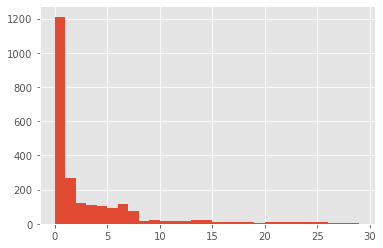

In [219]:
plt.hist(np.array(sampled_params)[:,-1],bins=np.arange(0,30,1));

In [62]:
import joblib

In [220]:
joblib.dump(sampled_params,'Control_Params3.joblib')

['Control_Params3.joblib']

## Plot Data

In [224]:
samp_params = joblib.load('Control_Params3.joblib')

In [225]:
params_df = pd.DataFrame(samp_params)
col_mapper = dict(zip([i for i in range(21)],['alpha','k2','k3','k4','kisp','d2','d3','d4','disp','ddp','r2','r3','r4','risp','rdp','dn20','dn30','dn40','isp0','dp0','ssr']))
params_df.rename(columns=col_mapper,inplace=True)

In [700]:
best_params = params_df[(params_df['ssr']<params_df['ssr'].quantile(.3))].sort_values(by='ssr')

In [701]:
best_params.shape

(1167, 21)

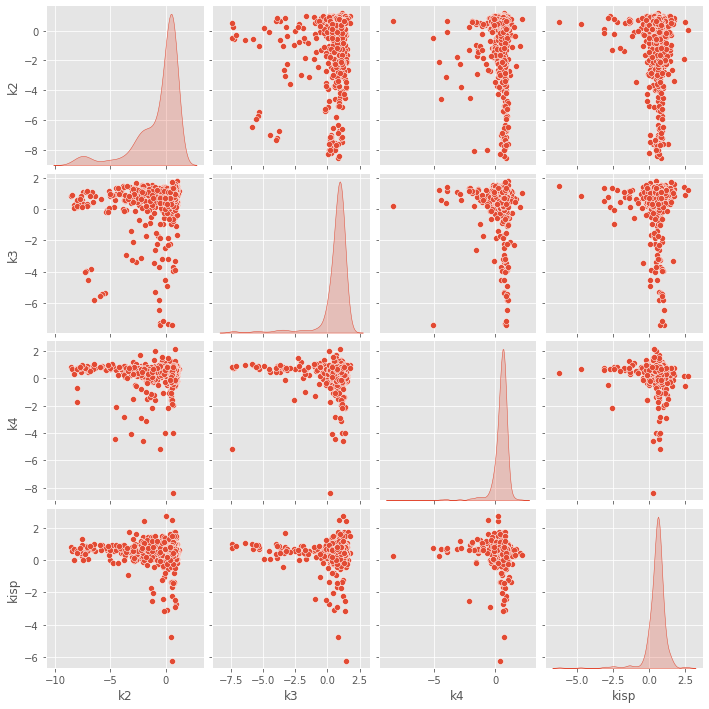

In [247]:
sns.pairplot(best_params.apply(np.log10),vars=['k2','k3','k4','kisp'],diag_kind='kde')

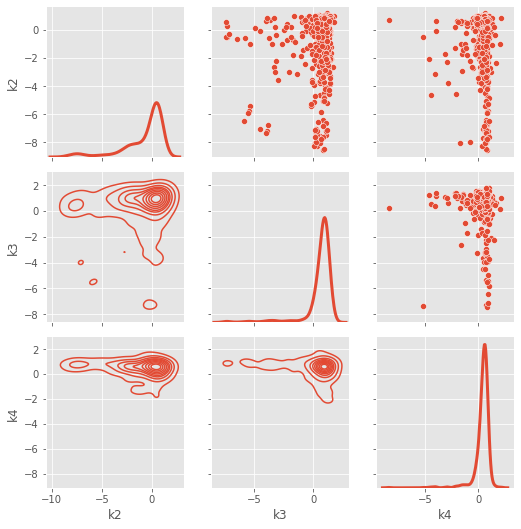

In [248]:
g = sns.PairGrid(best_params[['k2','k3','k4']].apply(np.log10),vars=['k2','k3','k4'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);


In [644]:
# KO_params = pd.read_csv('new_full_model_log2.csv',index_col=0).append(pd.read_csv('new_full_model_log.csv',index_col=0))
KO_params = pd.read_csv('Transplant_params2.csv',index_col=0)
col_mapper = dict(zip([str(i) for i in range(17)],['alpha','k3','k4','kisp','d3','d4','disp','ddp','r3','r4','risp','rdp','dn30','dn40','isp0','dp0','ssr']))
KO_params.rename(columns=col_mapper,inplace=True)

print((KO_params['ssr']<KO_params['ssr'].quantile(.2)).sum())

KO_params = KO_params[(KO_params['ssr']<KO_params['ssr'].quantile(.2))]

781


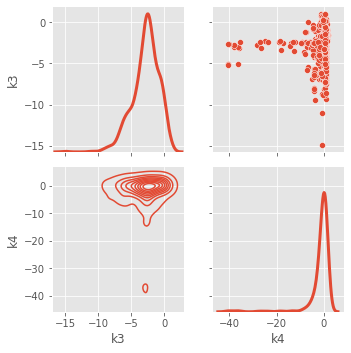

In [244]:
g = sns.PairGrid(KO_params[['k3','k4']].apply(np.log10),vars=['k3','k4'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);

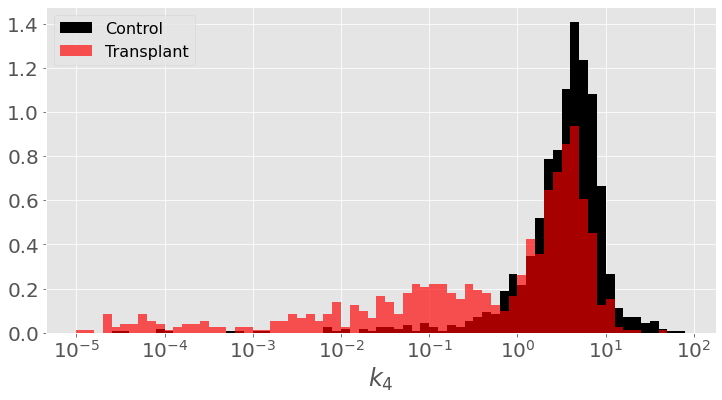

In [704]:
fig,ax = plt.subplots(figsize=(12,6))
ax.tick_params(axis='both', which='major', labelsize=20)
best_params['k4'].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,color='k',label='Control')
KO_params['k4'].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,color='r',alpha=.66,label='Transplant')

# sns.kdeplot(KO_params['k4'].apply(np.log10),log_scale=True)
plt.xticks(list(range(-5,3)),['$10^{'+str(i)+'}$' for i in list(range(-5,3))]);
plt.xlabel('$k_4$',fontdict={'size':24});
plt.legend(prop={'size': 16});
plt.savefig('k4_comparison.pdf')

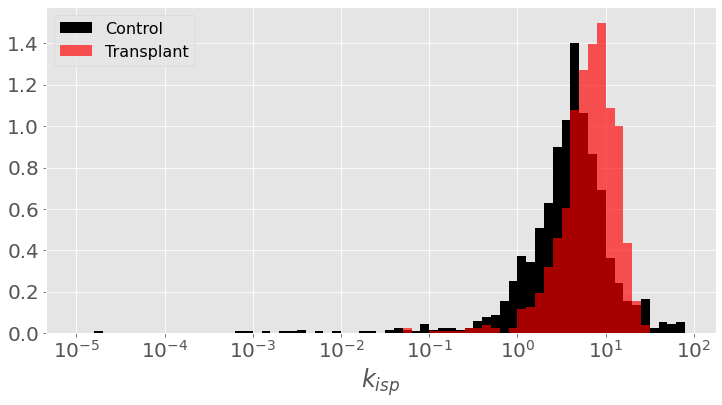

In [705]:

fig,ax = plt.subplots(figsize=(12,6))
ax.tick_params(axis='both', which='major', labelsize=20)
best_params['kisp'].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,color='k',label='Control')
KO_params['kisp'].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,color='r',alpha=.66,label='Transplant')

# sns.kdeplot(KO_params['k4'].apply(np.log10),log_scale=True)
plt.xticks(list(range(-5,3)),['$10^{'+str(i)+'}$' for i in list(range(-5,3))]);
plt.xlabel('$k_{isp}$',fontdict={'size':24})
plt.legend(prop={'size': 16});
plt.savefig('kisp_comparison.pdf')

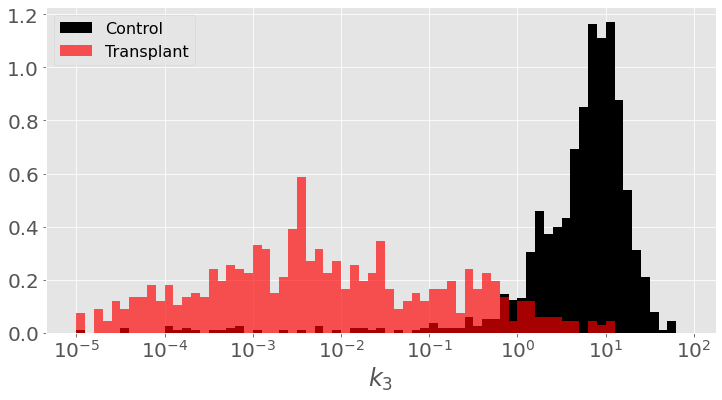

In [732]:

fig,ax = plt.subplots(figsize=(12,6))
ax.tick_params(axis='both', which='major', labelsize=20)
best_params['k3'].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,color='k',label='Control')
KO_params['k3'].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,color='r',alpha=.66,label='Transplant')

# sns.kdeplot(KO_params['k4'].apply(np.log10),log_scale=True)
plt.xticks(list(range(-5,3)),['$10^{'+str(i)+'}$' for i in list(range(-5,3))]);
plt.xlabel('$k_{3}$',fontdict={'size':24})
plt.legend(prop={'size': 16});
plt.savefig('k3_comparison.pdf')

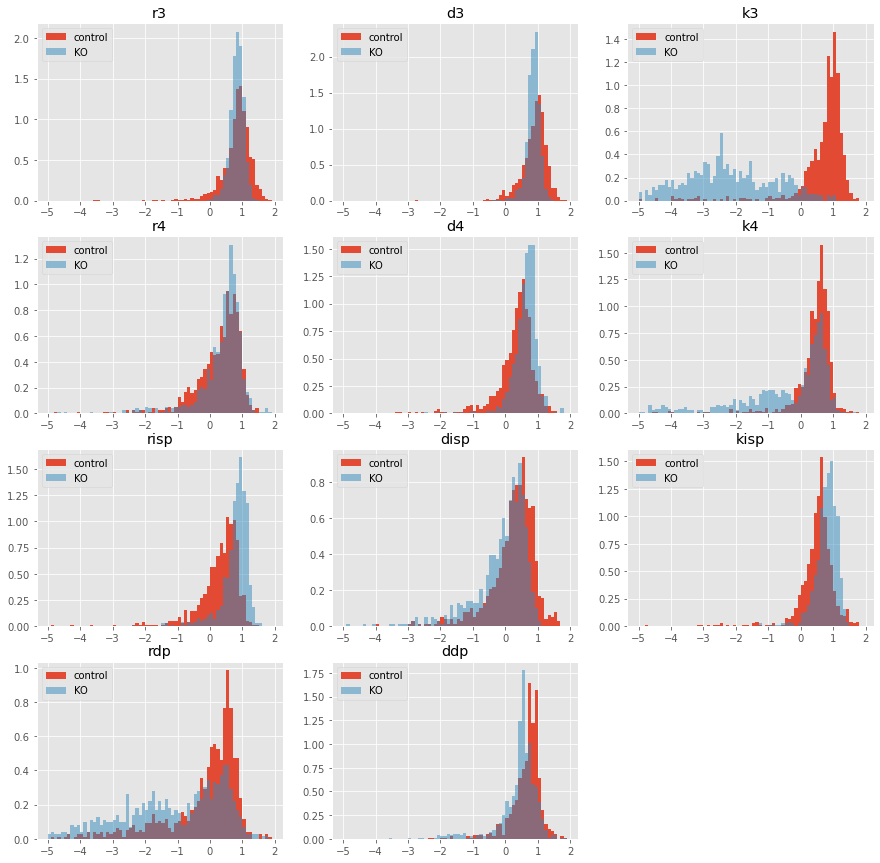

In [250]:
plt.subplots(figsize=(15,15))
for row,pop in enumerate(['3','4','isp','dp']):
    for col,param in enumerate(['r','d','k']):
        if param+pop=='kdp': continue
        plt.subplot(4,3,col + 3*row+1)
        best_params[param+pop].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,label='control')
        KO_params[param+pop].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,alpha=.5,label='KO')
        plt.title(param+pop)
        plt.legend(loc='upper left')

In [ ]:
plt.subplots(figsize=(15,15))
for row,pop in enumerate(['3','4','isp','dp']):
    for col,param in enumerate(['r','d','k']):
        if param+pop=='kdp': continue
        plt.subplot(4,3,col + 3*row+1)
        best_params[param+pop].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,label='control')
        KO_params[param+pop].apply(np.log10).hist(bins=np.arange(-5,2,.1),density=True,alpha=.5,label='KO')
        plt.title(param+pop)
        plt.legend(loc='upper left')

In [297]:
temp_df1 = KO_params.copy()
temp_df1['treatment'] = 'Transplant'

temp_df2 = best_params.copy()
temp_df2['treatment'] = 'Control'

plot_df = temp_df1.append(temp_df2[temp_df1.columns]).dropna()

In [298]:
plot_df.columns

Index(['alpha', 'k3', 'k4', 'kisp', 'd3', 'd4', 'disp', 'ddp', 'r3', 'r4',
       'risp', 'rdp', 'dn30', 'dn40', 'isp0', 'dp0', 'ssr', 'treatment'],
      dtype='object')

In [299]:
for col in ['k3','k4','kisp','r3','r4','risp','rdp','d3','d4','disp','ddp']:
    plot_df[col] = plot_df[col].apply(np.log10)
    

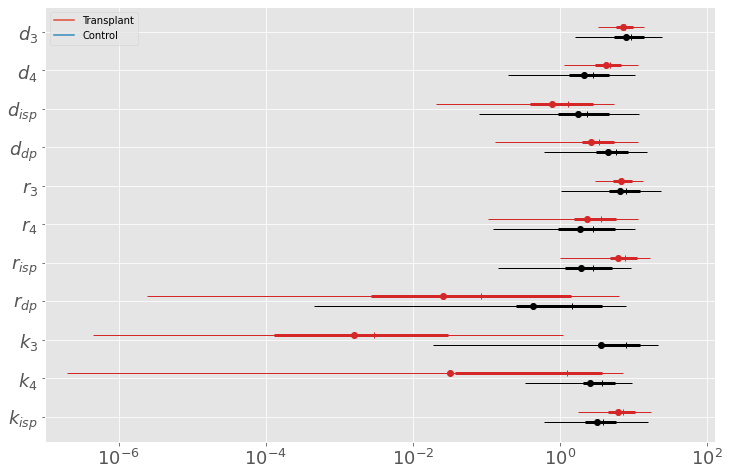

In [378]:
cols = ['kisp','k4','k3','rdp','risp','r4','r3','ddp','disp','d4','d3']
offset = .2

fig,ax = plt.subplots(figsize=(12,8))
for idx,col in enumerate(cols):
    df = plot_df[plot_df['treatment']=='Transplant']
    plt.plot([np.mean(df[col])],[idx*1.5+offset],marker='o',ls='',c='tab:red')
    plt.plot([np.median(df[col])],[idx*1.5+offset],marker='|',ls='',c='tab:red')
    plt.hlines(idx*1.5+offset,np.percentile(df[col],5),np.percentile(df[col],95),colors='tab:red',lw=1)
    plt.hlines(idx*1.5+offset,np.percentile(df[col],25),np.percentile(df[col],75),colors='tab:red',lw=3)
    
    
    df = plot_df[plot_df['treatment']=='Control']
    plt.plot([np.mean(df[col])],[idx*1.5-offset],marker='o',ls='',c='k')
    plt.plot([np.median(df[col])],[idx*1.5-offset],marker='|',ls='',c='k')
    plt.hlines(idx*1.5-offset,np.percentile(df[col],5),np.percentile(df[col],95),colors='k',lw=1)
    plt.hlines(idx*1.5-offset,np.percentile(df[col],25),np.percentile(df[col],75),colors='k',lw=3)

    
plt.yticks(np.array(list(range(len(cols))))*1.5,['$k_{isp}$','$k_4$','$k_3$','$r_{dp}$','$r_{isp}$','$r_4$','$r_3$','$d_{dp}$','$d_{isp}$','$d_4$','$d_3$']);
plt.xticks(range(-16,3,2),map(lambda x: '$10^{'+str(x)+'}$',list(range(-16,3,2))))
plt.xlim(-7,2.1)

plt.plot([0],[0],label='Transplant')
plt.plot([0],[0],label='Control')
plt.legend()

ax.tick_params(axis='both', which='major', labelsize=18)
# ax.tick_params(axis='both', which='minor', labelsize=8

Text(0.5, 0, '$k_4$')

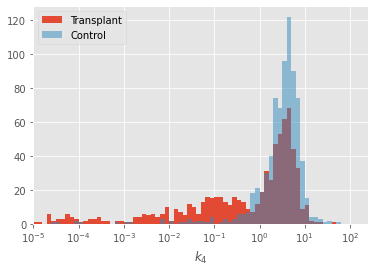

In [359]:
KO_params['k4'].apply(np.log10).hist(bins=np.arange(-15,2,.1),label='Transplant')
best_params['k4'].apply(np.log10).hist(bins=np.arange(-15,2,.1),alpha=.5,label='Control')
plt.xlim(-5,2.4)
plt.xticks(range(-5,3,1),map(lambda x: '$10^{'+str(x)+'}$',list(range(-5,3,1))))
plt.legend()
plt.xlabel('$k_4$')

Text(0.5, 0, '$k_3$')

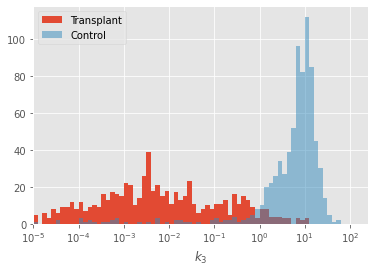

In [360]:
KO_params['k3'].apply(np.log10).hist(bins=np.arange(-15,2,.1),label='Transplant')
best_params['k3'].apply(np.log10).hist(bins=np.arange(-15,2,.1),alpha=.5,label='Control')
plt.xlim(-5,2.4)
plt.xticks(range(-5,3,1),map(lambda x: '$10^{'+str(x)+'}$',list(range(-5,3,1))))
plt.legend()
plt.xlabel('$k_3$')

In [ ]:
best_params['k4'].hist(bins=np.arange(-6)))
KO_params['k4'].hist(bins=np.arange(0,1,.01),alpha=.5)
# plt.xlim(-5,2.4)

<AxesSubplot:>

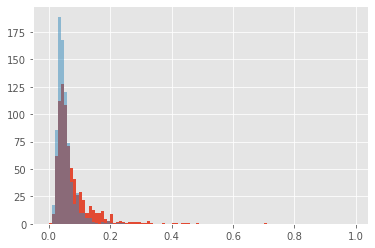

In [352]:
best_params['alpha'].hist(bins=np.arange(0,1,.01))
KO_params['alpha'].hist(bins=np.arange(0,1,.01),alpha=.5)
# plt.xlim(-5,2.4)

In [362]:
compatible = KO_params[KO_params['k4']>=1]

Text(0.5, 1.0, 'restricted to compatible $k_4$')

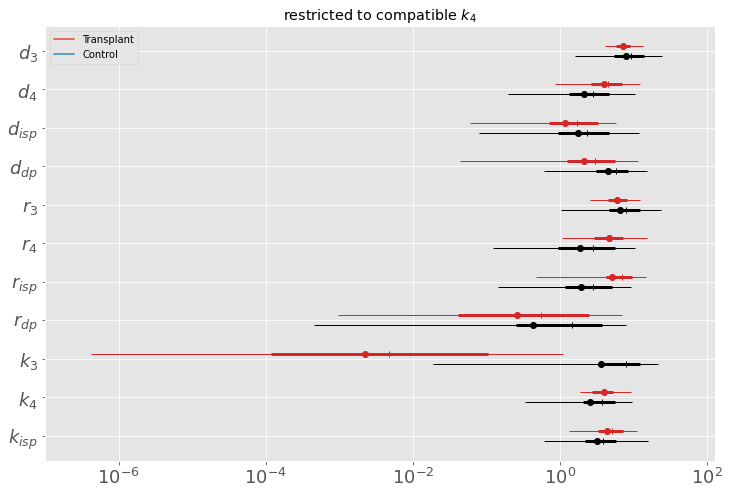

In [377]:
cols = ['kisp','k4','k3','rdp','risp','r4','r3','ddp','disp','d4','d3']
offset = .2

fig,ax = plt.subplots(figsize=(12,8))
for idx,col in enumerate(cols):
    df = plot_df[(plot_df['treatment']=='Transplant')&(plot_df['k4']>=.2)]
    plt.plot([np.mean(df[col])],[idx*1.5+offset],marker='o',ls='',c='tab:red')
    plt.plot([np.median(df[col])],[idx*1.5+offset],marker='|',ls='',c='tab:red')
    plt.hlines(idx*1.5+offset,np.percentile(df[col],5),np.percentile(df[col],95),colors='tab:red',lw=1)
    plt.hlines(idx*1.5+offset,np.percentile(df[col],25),np.percentile(df[col],75),colors='tab:red',lw=3)
    
    
    df = plot_df[(plot_df['treatment']=='Control')]
    plt.plot([np.mean(df[col])],[idx*1.5-offset],marker='o',ls='',c='k')
    plt.plot([np.median(df[col])],[idx*1.5-offset],marker='|',ls='',c='k')
    plt.hlines(idx*1.5-offset,np.percentile(df[col],5),np.percentile(df[col],95),colors='k',lw=1)
    plt.hlines(idx*1.5-offset,np.percentile(df[col],25),np.percentile(df[col],75),colors='k',lw=3)

    
plt.yticks(np.array(list(range(len(cols))))*1.5,['$k_{isp}$','$k_4$','$k_3$','$r_{dp}$','$r_{isp}$','$r_4$','$r_3$','$d_{dp}$','$d_{isp}$','$d_4$','$d_3$']);
plt.xticks(range(-16,3,2),map(lambda x: '$10^{'+str(x)+'}$',list(range(-16,3,2))))
plt.xlim(-7,2.1)

plt.plot([0],[0],label='Transplant')
plt.plot([0],[0],label='Control')
plt.legend()

ax.tick_params(axis='both', which='major', labelsize=18)
plt.title('restricted to compatible $k_4$')

In [438]:
best_params.shape,KO_params.shape

((39, 21), (781, 17))

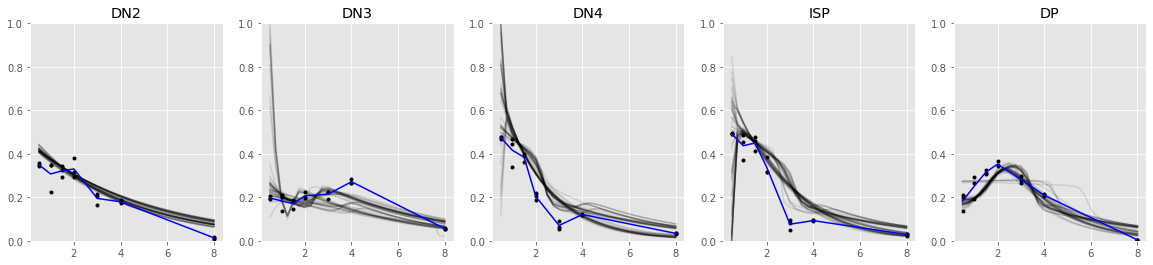

In [744]:
# params = alpha,k2,k3,k4,kisp,d2,d3,d4,disp,ddp,r2,r3,r4,risp,rdp
# y0 = [Ns[0]*dn20,Ns[1]*dn30,Ns[2]*dn40,Ns[3]*isp0,Ns[4]*dp0,Ns[0]*(1-dn20),Ns[1]*(1-dn30),Ns[2]*(1-dn40),Ns[3]*(1-isp0),Ns[4]*(1-dp0)]

variabs = ['DN2','DN3','DN4','ISP','DP']


fig,ax = plt.subplots(figsize=(20,4))
for k,var in enumerate(variabs):
    plt.subplot(1,5,k+1)
    for j in range(50):
        par = best_params.iloc[j].tolist()
        params = par[:15]
        dn20,dn30,dn40,isp0,dp0 = par[-6:-1]
#         y0 = 1000*np.array([Ns[0]*dn20,Ns[1]*dn30,Ns[2]*dn40,Ns[3]*isp0,Ns[4]*dp0,Ns[0]*(1-dn20),Ns[1]*(1-dn30),Ns[2]*(1-dn40),Ns[3]*(1-isp0),Ns[4]*(1-dp0)])
        y0 = 1000000*np.array([Ns[0]*dn20,Ns[1]*dn30,Ns[2]*dn40,Ns[3]*isp0,Ns[4]*dp0,Ns[0]*(1-dn20),Ns[1]*(1-dn30),Ns[2]*(1-dn40),Ns[3]*(1-isp0),Ns[4]*(1-dp0)])

        tt=data['timepoint'].unique()
        tt = np.arange(.5,8.1,.25)
        psoln = odeint(f_full,y0,tt,args=(params,))
        plt.plot(tt,psoln[:,k]/(psoln[:,k]+psoln[:,k+5]),alpha=.1,c='k')
        plt.ylim(0,1)
    
    plt.plot(data['timepoint'],data[var+'_frac'],ls='',marker='.',c='k')
    mean_df = data[['timepoint',var+'_frac']].groupby(by='timepoint').agg('mean')
    plt.plot(mean_df.index,mean_df[var+'_frac'],c='b')
    
    plt.title(var)
    
plt.savefig('Control-timeseries2.pdf')

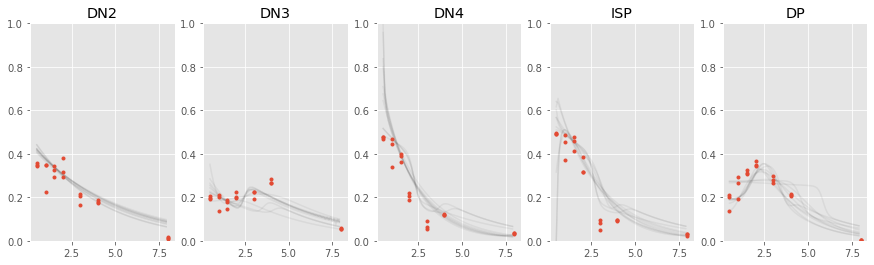

In [491]:

variabs = ['DN2','DN3','DN4','ISP','DP']


fig,ax = plt.subplots(figsize=(15,4))
for k,var in enumerate(variabs):
    plt.subplot(1,5,k+1)
    for j in range(10):
        par = best_params.iloc[j].tolist()
        params = par[:15]
        dn20,dn30,dn40,isp0,dp0 = par[-6:-1]
        y0 = 100*np.array([Ns[0]*dn20,Ns[1]*dn30,Ns[2]*dn40,Ns[3]*isp0,Ns[4]*dp0,Ns[0]*(1-dn20),Ns[1]*(1-dn30),Ns[2]*(1-dn40),Ns[3]*(1-isp0),Ns[4]*(1-dp0)])

        tt=np.arange(.5,8,.1)
        psoln = odeint(f_full,y0,tt,args=(params,))
        plt.plot(tt,psoln[:,k]/(psoln[:,k]+psoln[:,k+5]),alpha=.05,c='k')
        plt.ylim(0,1)
        
    plt.plot(data['timepoint'],data[var+'_frac'],ls='',marker='.')
    plt.title(var)
    

## graph with density of parameter k3 vs k4

In [522]:
import seaborn as sns

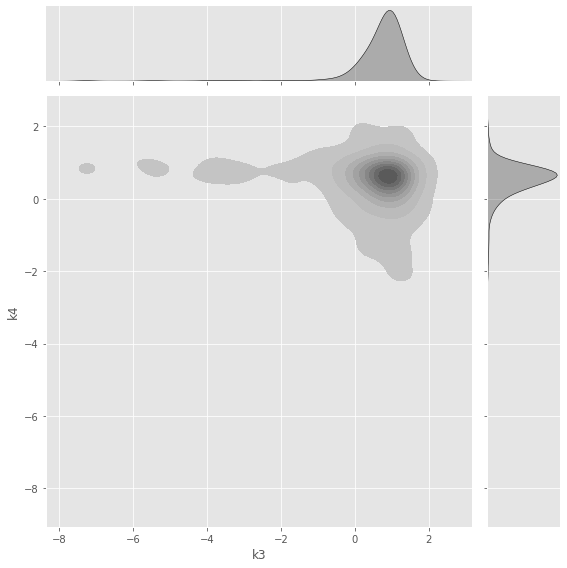

In [728]:
sns.jointplot(data=best_params[['k3','k4']].apply(np.log10),x='k3',y='k4',kind='kde',fill=True,color='k',height=8)
plt.savefig('Control-k3vsk4.pdf')

In [745]:
best_params2 = best_params[(best_params['r4']>best_params['r3'])&(best_params['r4']>best_params['rdp'])&(best_params['risp']>best_params['r3'])&(best_params['risp']>best_params['rdp'])]

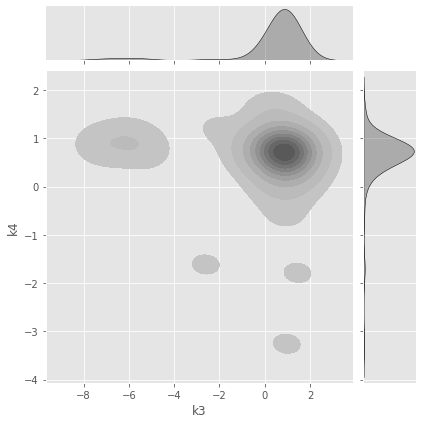

In [749]:
sns.jointplot(data=best_params2[['k3','k4']].apply(np.log10),x='k3',y='k4',kind='kde',fill=True,color='k',)

plt.savefig('Control-k3vsk4_biologically_relevant.pdf')

In [641]:
 pd.read_csv('Transplant_params2.csv',index_col=0)

,alpha,k3,k4,kisp,d3,d4,disp,ddp,r3,r4,risp,rdp,dn30,dn40,isp0,dp0,ssr
0,0.078629,9.694369,5.643840,11.018546,8.664238,0.105317,4.101878,6.546204,6.296712,1.770509,1.658278,1.891798,0.977547,1.034469e-03,0.996227,8.998139e-03,2.804865e+01
1,0.733267,4.342808,7.039210,0.546703,8.157593,3.583903,3.730737,5.398492,1.535187,3.333258,7.145847,1.499412,0.999616,1.365893e-07,1.000000,3.331653e-07,2.906544e+06
2,0.201691,5.988517,12.199068,97.497808,4.412105,3.202803,71.800972,24.648687,1.126825,4.354456,6.742786,9.814020,0.854497,3.177065e-02,0.999741,5.499950e-01,2.891436e+01
3,0.035523,3.687851,2.329145,7.823332,8.278852,8.105905,2.705214,7.432986,8.181059,7.757118,6.567279,2.493749,0.735877,1.611021e-05,0.986964,8.433981e-02,1.662702e+01
4,0.426458,13.539234,9.182542,1.393673,3.251549,1.229588,9.252994,1.383873,8.297807,4.582512,6.136261,1.022340,0.999977,9.694298e-05,0.999973,7.685070e-04,6.450454e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,0.497871,5.686002,9.729152,3.755744,10.040433,3.822552,7.781531,4.596438,10.310516,3.991787,7.119011,3.401490,1.000000,1.000010e-10,1.000000,1.000007e-10,4.680100e+12
3898,0.024763,0.000630,1.203392,13.461882,12.905390,3.325747,2.753135,0.010866,12.874747,1.834195,17.200009,0.000071,0.853429,2.786124e-01,0.974667,8.659594e-02,1.422696e+01
3899,0.602361,6.928283,1.731018,2.769383,5.053762,2.017535,3.290012,7.853596,0.877050,4.582877,0.004197,2.154407,0.999945,7.926384e-04,0.999855,1.010612e-03,4.585383e+02
3900,0.057305,3.599940,4.197970,5.889539,4.077106,5.917133,8.487372,32.285225,5.067346,4.351076,3.120661,8.225092,0.657670,1.330765e-02,0.570076,1.103680e-01,2.090151e+01


In [708]:
KO_params2 = pd.read_csv('Transplant_params2.csv',index_col=0)
# col_mapper = dict(zip([str(i) for i in range(17)],['alpha','k3','k4','kisp','d3','d4','disp','ddp','r3','r4','risp','rdp','dn30','dn40','isp0','dp0','ssr']))
# KO_params2.rename(columns=col_mapper,inplace=True)

print((KO_params2['ssr']<KO_params2['ssr'].quantile(.3)).sum())
KO_params2= KO_params2[(KO_params2['ssr']<KO_params2['ssr'].quantile(.3))]

1171


KO_params2 = KO_params2[(KO_params2['k3']>10**-12)&(KO_params2['k4']>10**-12)]

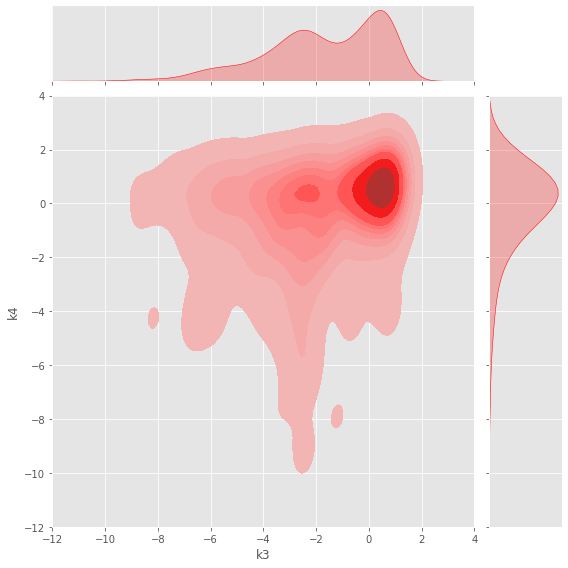

In [729]:
sns.jointplot(data=KO_params2[['k3','k4']].apply(np.log10),x='k3',y='k4',kind='kde',\
              fill=True,color='r',xlim=(-12,4),ylim=(-12,4),height=8,bw_adjust=.6)
plt.savefig('Transplant-k3vsk4.pdf')

restricting to biologically reasonable parameters

In [747]:
KO_params_rel = KO_params2[(KO_params2['r4']>KO_params2['r3'])&(KO_params2['r4']>KO_params2['rdp'])&(KO_params2['risp']>KO_params2['r3'])&(KO_params2['risp']>KO_params2['rdp'])]

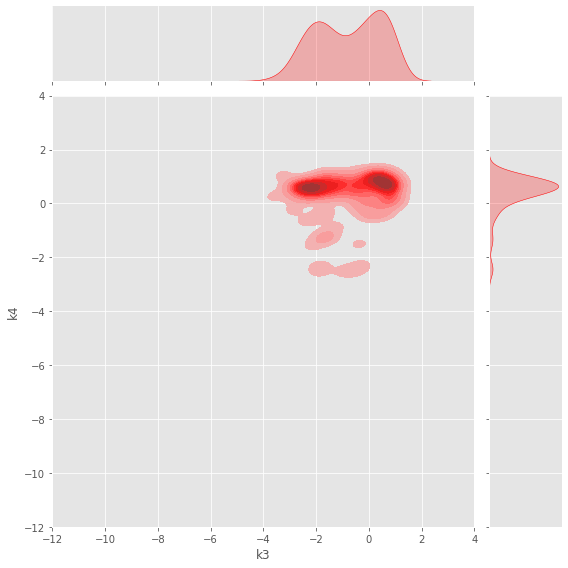

In [750]:
sns.jointplot(data=KO_params_rel[['k3','k4']].apply(np.log10),x='k3',y='k4',kind='kde',\
              fill=True,color='r',xlim=(-12,4),ylim=(-12,4),height=8,marginal_kws={'bw_adjust':1},bw_adjust=.6)
plt.savefig('Transplant-k3vsk4_biologicalrelevant.pdf')

In [776]:
best_params = params_df[(params_df['ssr']<params_df['ssr'].quantile(.1))].sort_values(by='ssr')

In [777]:
residuals = []
for j in range(len(best_params)):
#     par = best_params.iloc[j].tolist()
    par = best_params.iloc[j].tolist()
    params = par[:-1]
    # no k4
    params[3]=0
    res = calc_residuals(full_model,dfs['t'],dfs['y'] , params)
    residuals.append([par[-1],res])

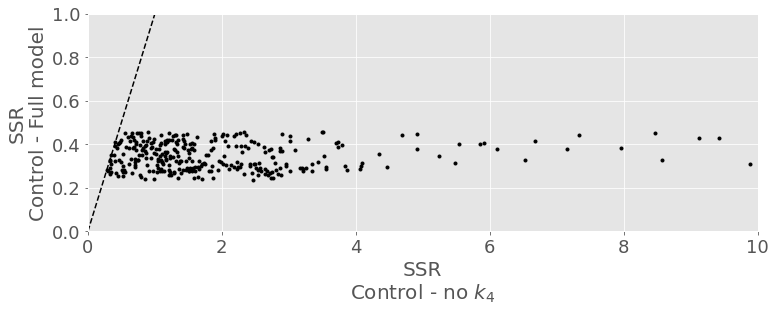

In [779]:
fig,ax = plt.subplots(figsize=(12,4))
plt.plot(np.array(residuals).T[1],np.array(residuals).T[0],marker='.',ls='',color='k')
plt.plot([0,20],[0,20],ls='--',c='k')
plt.xlim(0,10)
plt.ylim(0,1)
plt.xlabel('SSR\nControl - no $k_4$',fontdict={'size':20})
plt.ylabel('SSR\nControl - Full model',fontdict={'size':20})
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('SSR_k4_control.pdf')